In [1]:
import torch
from torch import nn
import torchvision
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

from torchvision import transforms, models, datasets
from PIL import Image
from torch import optim

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Currently operating on {device}')
import cv2, glob, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from random import shuffle, seed 
from glob import glob
from torchsummary import summary

Currently operating on cpu


In [2]:
#Sort values in the csv values to concord with the file
df = pd.read_csv('C:/Python_projects/road evolution/metadata.csv')

df.head()

,filename,label
0,dirty_1.jpg,0
1,dirty_2.jpg,0
2,clean_1.jpg,1
3,clean_2.jpg,1


In [3]:
mypath = 'C:/Python_projects/road evolution/Images'
#Organize clean and dirty images in two sections
clean = glob(mypath + '/clean*')
dirty = glob(mypath + '/dirty*')
fpaths = clean+dirty
# Check the len of our images file and len of our dataframe
print(f'CSV shape: {df.shape}, img_file shape: {len(fpaths)}')

CSV shape: (4, 2), img_file shape: 4


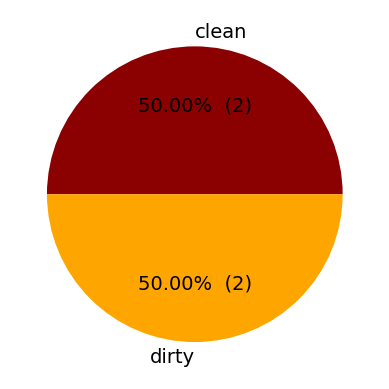

In [4]:
#df.sort_values(by="filename", key=lambda column: column.map(lambda e: fpaths_split.index(e)), inplace=True)
#df = df.reset_index(drop=True)


# Plot to see the distribution 
df_label = df['label'].value_counts()
plt.figure(figsize=plt.figaspect(1))
values = [df_label[0], df_label[1]]
labels = ['clean', 'dirty']
colors = ['darkred','orange']
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct
plt.pie(values, labels=labels, autopct=make_autopct(values), textprops={'fontsize': 14}, colors = colors)
plt.style.use('classic')
plt.show()

In [5]:
fpaths_train = fpaths[2:3]
fpaths_test = fpaths[0:2]
fpaths_test.extend(fpaths[3:])

#If you want to make sure that there is no same images in both files - run the following code:
check =  any(item in fpaths_test for item in fpaths_train)
 
if check is True:
    print("The test list  contains some elements of the train list ")    
else :
    print("No, test list doesn't have any elements of the train list.")

No, test list doesn't have any elements of the train list.


In [6]:
class clean_dirty(Dataset):
    def __init__(self, folder):
        #clean = glob(folder + '/clean*')
        #dirty = glob(folder + '/dirty*')
        self.fpaths = folder
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std = [0.229, 0.224, 0.225])
        shuffle(self.fpaths)
        self.targets = [fpath.split('/')[-1].startswith('dirty') for fpath in self.fpaths]
    def __len__(self):
        return len(self.fpaths)
    def __getitem__ (self, ix):
        f = self.fpaths[ix]
        target = self.targets[ix]
        im = (cv2.imread(f)[:,:,::-1])
        im = cv2.resize(im, (224,224))
        im = torch.tensor(im/255)
        im = im.permute(2,0,1)
        im = self.normalize(im)
        return im.float().to(device), torch.tensor([target]).float().to(device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])
C:/Python_projects/road evolution/Images\clean_1.jpg
tensor([0.])


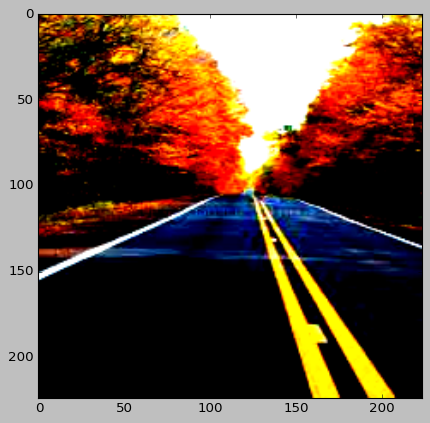

In [7]:
train = clean_dirty(fpaths_test)
import random

idx = random.randint(0, len(train)-1)

im, label = train[idx]
print(im.shape)
print(train.fpaths[idx])
plt.imshow(im.permute(1,2,0).to('cpu')) # Don't forget to load the image on cpu since Matplot does not operate with cuda 
print(label)

In [8]:
model = models.vgg16(pretrained = True).to(device)
summary(model, input_size = (3,224,224))

C:\Users\Goutham\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Goutham\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [9]:
def get_model():
    model = models.vgg16(pretrained = True)
    for param in model.parameters():
        param.requires_grad = False
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
    model.classifier = nn.Sequential(nn.Flatten(),
                                     nn.Linear(512,128),
                                     nn.ReLU(),
                                     nn.Dropout(0.2),
                                     nn.Linear(128,1),
                                     nn.Sigmoid())
    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
    return model.to(device), loss_fn, optimizer


In [10]:
custom_model, criterion, optimizer = get_model()
summary(custom_model, input_size = (3,224,224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [11]:
def train_batch(x,y,model,opt,loss_fn):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()  
    return batch_loss.item()

@torch.no_grad() #This is a decorator that blocks and gradient computations for our accuracy function.
def accuracy(x,y, model):
    model.eval()
    prediction = model(x)
    is_correct = (prediction > 0.5) == y
    return is_correct.cpu().numpy().tolist()

def get_data():

    train_data = clean_dirty(fpaths_train)
    test_data = clean_dirty(fpaths_test)

    trn_dl = DataLoader(train_data, batch_size = 1, shuffle = True, 
                        drop_last = True)
    val_dl = DataLoader(test_data, batch_size = 1, shuffle = True, 
                        drop_last = True)
    
    return trn_dl, val_dl

In [12]:
trn_dl, val_dl = get_data()
model,loss_fn, optimizer = get_model()

In [13]:
train_losses, train_accuracies = [], []
val_accuracies = []

# xtr = torch.empty((32,3,224,224))

for epoch in range(15):#changed it for speed
    print(f'epoch {epoch+1}/15')
    train_epoch_losses, train_epoch_accuracies = [], []
    val_epoch_accuracies = []
    
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        # print(x.shape)
        batch_loss = train_batch(x,y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)
    train_epoch_loss = np.array(train_epoch_losses).mean()
    print(f'Loss for current epoch of {epoch+1} is {train_epoch_loss}')

    
    for ix, batch in enumerate(iter(trn_dl)):
        x,y = batch
        is_correct = accuracy(x,y,model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)
    print(f'Accuracy the for current epoch of {epoch+1} is {train_epoch_accuracy}')
    
    for ix, batch in enumerate(iter(val_dl)):
        x,y = batch
        val_is_correct = accuracy(x,y,model)
        val_epoch_accuracies.extend(val_is_correct)
    val_epoch_accuracy = np.mean(val_epoch_accuracies)
    print(f'Val accuracy for current epoch of {epoch+1} is {val_epoch_accuracy}')
    
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_accuracies.append(val_epoch_accuracy)

epoch 1/15
Loss for current epoch of 1 is 0.6480219960212708
Accuracy the for current epoch of 1 is 1.0
Val accuracy for current epoch of 1 is 1.0
epoch 2/15
Loss for current epoch of 2 is 0.4716077148914337
Accuracy the for current epoch of 2 is 1.0
Val accuracy for current epoch of 2 is 1.0
epoch 3/15
Loss for current epoch of 3 is 0.35340622067451477
Accuracy the for current epoch of 3 is 1.0
Val accuracy for current epoch of 3 is 1.0
epoch 4/15
Loss for current epoch of 4 is 0.32703039050102234
Accuracy the for current epoch of 4 is 1.0
Val accuracy for current epoch of 4 is 1.0
epoch 5/15
Loss for current epoch of 5 is 0.28205305337905884
Accuracy the for current epoch of 5 is 1.0
Val accuracy for current epoch of 5 is 1.0
epoch 6/15
Loss for current epoch of 6 is 0.17680740356445312
Accuracy the for current epoch of 6 is 1.0
Val accuracy for current epoch of 6 is 1.0
epoch 7/15
Loss for current epoch of 7 is 0.16403096914291382
Accuracy the for current epoch of 7 is 1.0
Val accur

C:\Users\Goutham\AppData\Local\Temp\ipykernel_13884\2099564227.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


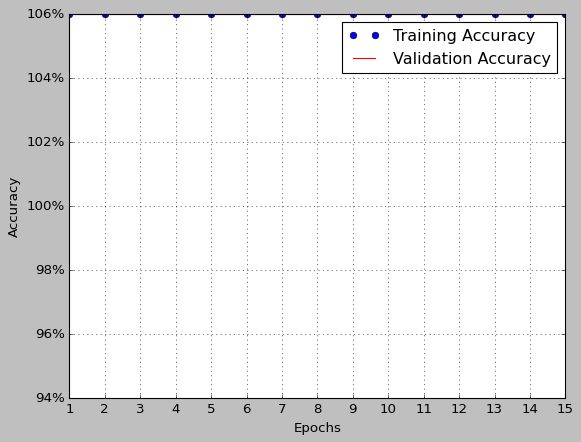

In [14]:
import matplotlib.ticker as mticker
from matplotlib.pyplot import figure

epochs = np.arange(15) + 1
figure(figsize=(8, 6), dpi=80)
plt.plot(epochs, train_accuracies, 'bo',
         label = 'Training Accuracy')
plt.plot(epochs, val_accuracies, 'r',
         label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.ylim(0.70,1)
plt.legend()
plt.grid('off')
plt.show()
    

In [15]:
import urllib
import cv2


def predict_custom_img(url):
    
    resp = urllib.request.urlopen(url)
    img = np.asarray(bytearray(resp.read()), dtype = 'uint8')
    img = cv2.imdecode(img, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img1 = cv2.resize(img, (224,224))
    img1 = torch.tensor(img1/255).permute(2,0,1).to(device).float()
    img1 = torch.unsqueeze(img1,0)
    img1 = img1.permute(0,1,2,3)
    print(img1.shape)
    prediction = model(img1)
    if prediction < 0.5:
        a = str(f'This is a clean street with a score: {prediction}')
    else:
        a = str(f'This is a dirty street with a score: {prediction}')
    plt.style.use('dark_background')
    plt.imshow(img)
    plt.title(a)
    return img1

torch.Size([1, 3, 224, 224])


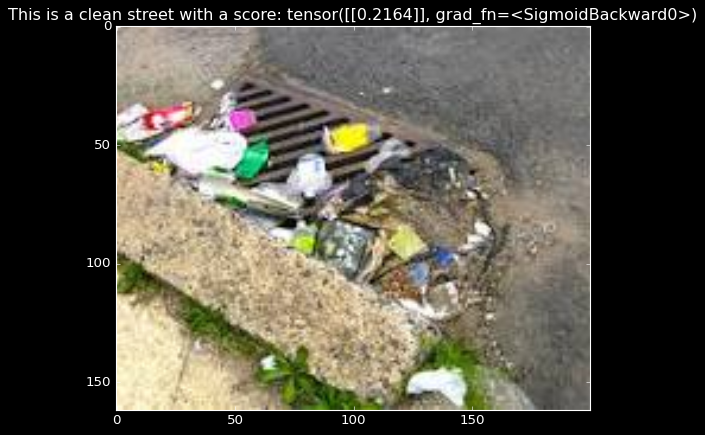

In [16]:
img = predict_custom_img('https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRxQQ-W2MmOaBmmBoOX0siHCFnQlRNOqquYBkUm8h2iRQ&s')

In [16]:
import urllib
import cv2
import numpy as np
import torch
import base64  # Added import statement for base64

def predict_custom_img(url):
    resp = urllib.request.urlopen(url)
    img = np.asarray(bytearray(resp.read()), dtype='uint8')
    img = cv2.imdecode(img, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, (224, 224))
    img_normalized = torch.tensor(img_resized / 255).permute(2, 0, 1).unsqueeze(0).float().to(device)
    img_normalized = img_normalized.permute(0, 1, 2, 3)
    prediction = model(img_normalized)
    if prediction < 0.5:
        result_text = f'This is a clean street with a score: {prediction}'
    else:
        result_text = f'This is a dirty street with a score: {prediction}'
    return img, result_text

# HTML template for the output
html_template = """
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Image Classifier</title>
    <script>
        function onSubmit() {
            var url = document.getElementById('url_input').value;
            fetch('/predict', {
                method: 'POST',
                headers: {
                    'Content-Type': 'application/json',
                },
                body: JSON.stringify({ url: url }),
            })
            .then(response => response.json())
            .then(data => {
                document.getElementById('result').innerHTML = data.result_text;
                document.getElementById('image').src = data.image_data;
            })
            .catch((error) => {
                console.error('Error:', error);
            });
        }
    </script>
</head>
<body>
    <h1>Image Classifier</h1>
    <input type="text" id="url_input" placeholder="Enter Image URL">
    <button onclick="onSubmit()">Submit</button>
    <div id="result"></div>
    <img id="image" src="" alt="Image" style="max-width: 100%;">
</body>
</html>
"""

# Flask web application to serve the HTML page and handle predictions
from flask import Flask, request, jsonify
from flask_ngrok import run_with_ngrok

app = Flask(__name__)
run_with_ngrok(app)  # Start ngrok when app is run

@app.route('/')
def home():
    return html_template

@app.route('/predict', methods=['POST'])
def predict():
    data = request.get_json()
    url = data['url']
    img, result_text = predict_custom_img(url)
    _, img_encoded = cv2.imencode('.png', img)
    # Encode the image data directly into base64
    img_base64 = 'data:image/png;base64,' + base64.b64encode(img_encoded).decode('ascii')
    return jsonify({'result_text': result_text, 'image_data': img_base64})

if __name__ == '__main__':
    app.run()


 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
Exception in thread Thread-6:
Traceback (most recent call last):
  File "C:\Users\Goutham\AppData\Roaming\Python\Python312\site-packages\urllib3\connection.py", line 198, in _new_conn
    sock = connection.create_connection(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Goutham\AppData\Roaming\Python\Python312\site-packages\urllib3\util\connection.py", line 85, in create_connection
    raise err
  File "C:\Users\Goutham\AppData\Roaming\Python\Python312\site-packages\urllib3\util\connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [WinError 10061] No connection could be made because the target machine actively refused it

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "C:\Users\Goutham\AppData\Roaming\Python\Python312\site-packages\urllib3\connectionpool.py", line 793, in urlopen
    response = self._make_request(
  